## MNIST Autoencoder

**Imports**

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

**Prepare the Dataset**

In [2]:
def map_image(image, label):
  image = image / 255
  image = tf.reshape(image, shape=(784,))
  return image, image

In [3]:
# Load the train and test sets from TFDS

BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

(train_dataset, test_dataset), info = tfds.load('mnist', as_supervised=True, split=["train", "test"], with_info=True)

train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()
test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/root/tensorflow_datasets/mnist/3.0.1.incompleteT4X2XH',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",

In [5]:
for im, im2 in train_dataset.take(1):
  print(im.shape)

(128, 784)


**Build the Model**

In [6]:
tf.keras.backend.clear_session()

def simple_autoencoder(inputs):
  encoder = tf.keras.layers.Dense(units=32, activation='relu')(inputs)
  decoder = tf.keras.layers.Dense(units=784, activation='sigmoid')(encoder)

  return encoder, decoder

inputs =  tf.keras.layers.Input(shape=(784,))
encoder_output, decoder_output = simple_autoencoder(inputs)
encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_output)

autoencoder_model = tf.keras.Model(inputs=inputs, outputs=decoder_output)

In [7]:
autoencoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 32)                25120     
                                                                 
 dense_1 (Dense)             (None, 784)               25872     
                                                                 
Total params: 50992 (199.19 KB)
Trainable params: 50992 (199.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


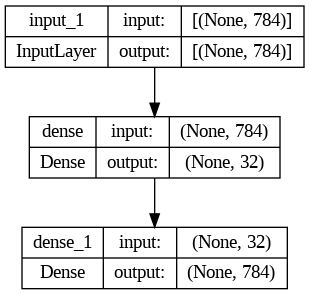

In [8]:
tf.keras.utils.plot_model(autoencoder_model,show_shapes=True, show_layer_names=True)

**Compile the Model**

In [9]:
autoencoder_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy')

**Train the Model**

In [10]:
train_steps = 60000 // BATCH_SIZE
test_steps = 10000 // BATCH_SIZE
simple_auto_history = autoencoder_model.fit(train_dataset,
                                            validation_data=test_dataset,
                                            steps_per_epoch=train_steps,
                                            validation_steps=test_steps,
                                            epochs=50)

Epoch 1/50
468/468 [==============================] - 23s 36ms/step - loss: 0.2285 - val_loss: 0.1604
Epoch 2/50
468/468 [==============================] - 8s 18ms/step - loss: 0.1424 - val_loss: 0.1273
Epoch 3/50
468/468 [==============================] - 3s 7ms/step - loss: 0.1202 - val_loss: 0.1118
Epoch 4/50
468/468 [==============================] - 3s 7ms/step - loss: 0.1083 - val_loss: 0.1029
Epoch 5/50
468/468 [==============================] - 5s 11ms/step - loss: 0.1015 - val_loss: 0.0978
Epoch 6/50
468/468 [==============================] - 3s 7ms/step - loss: 0.0977 - val_loss: 0.0950
Epoch 7/50
468/468 [==============================] - 3s 7ms/step - loss: 0.0958 - val_loss: 0.0939
Epoch 8/50
468/468 [==============================] - 4s 8ms/step - loss: 0.0949 - val_loss: 0.0933
Epoch 9/50
468/468 [==============================] - 4s 9ms/step - loss: 0.0944 - val_loss: 0.0929
Epoch 10/50
468/468 [==============================] - 3s 6ms/step - loss: 0.0941 - val_loss: 0.

**Display sample results**

In [12]:
def display_one_row(disp_images, offset, shape=(28, 28)):
  for idx, test_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(28,28,))
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20, shape=(28,28,))

1/1 [==============================] - 1s 543ms/step


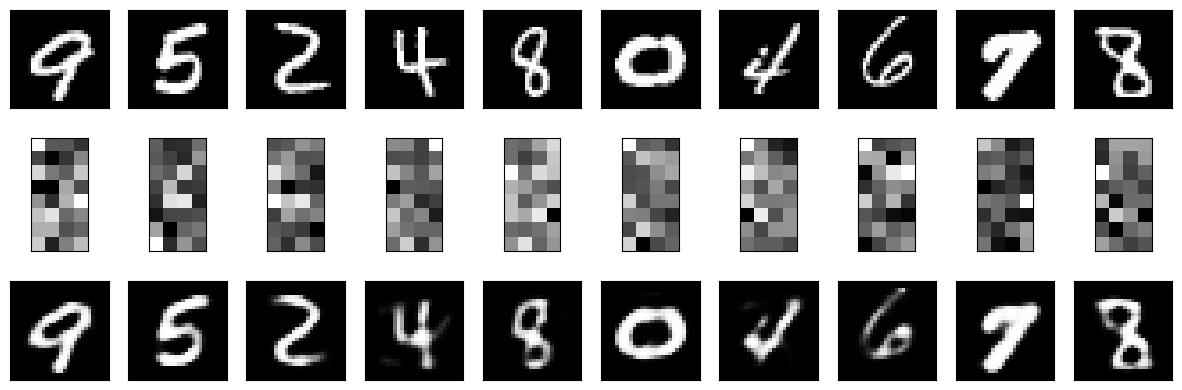

In [13]:
test_dataset = test_dataset.take(1)

output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

idxs = np.random.choice(BATCH_SIZE, size=10)

encoded_predicted = encoder_model.predict(test_dataset)

simple_predicted = autoencoder_model.predict(test_dataset)

display_results(output_samples[idxs], encoded_predicted[idxs], simple_predicted[idxs])

In [15]:
encoded_predicted.shape, simple_predicted.shape

((128, 32), (128, 784))